In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import natsort
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power

In [3]:
src_path: str = "../src"
sys.path.append(src_path)

In [4]:
ROOT: Path = Path("/Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED")
FIGURES_PATH: Path = ROOT.joinpath("manuscript_figures")
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
SUPPLEMENTARY_FILES_PATH: Path = ROOT.joinpath("supplementary_files")
SUPPLEMENTARY_FILES_PATH.mkdir(parents=True, exist_ok=True)

## Dataset and sample type table

---


In [6]:
ANNOT_DF: pd.DataFrame = pd.read_csv(
    ROOT.joinpath("data").joinpath("samples_annotation.csv"),
    index_col=0,
)
display(ANNOT_DF)

,patient_id,sample_type,dataset,library_type
sample_id,,,,
entry_357,TCGA-G9-6342-01,prim,TCGA,poly_a
entry_498,TCGA-VP-A875-01,prim,TCGA,poly_a
entry_520,TCGA-J4-A83I-01,prim,TCGA,poly_a
entry_521,TCGA-EJ-A8FP-01,prim,TCGA,poly_a
entry_522,TCGA-J4-A83J-01,prim,TCGA,poly_a
...,...,...,...,...
SRR22868633,SAMN32372352,hspc,GSE221601,total_rna
SRR22868634,SAMN32372353,hspc,GSE221601,total_rna
SRR22868635,SAMN32372354,hspc,GSE221601,total_rna


In [7]:
ANNOT_DF["group_dataset"] = [
    row["dataset"] if row["dataset"] in ["GSE221601", "WCDT"] else "PCTA"
    for _, row in ANNOT_DF.iterrows()
]

In [8]:
# Create a cross-tabulation with multi-index for rows
dataset_sample_type_counts = pd.crosstab(
    [ANNOT_DF["group_dataset"], ANNOT_DF["dataset"]], ANNOT_DF["sample_type"]
)

# Reorder the group_dataset values
group_dataset_order = ["PCTA", "WCDT", "GSE221601"]
dataset_sample_type_counts = dataset_sample_type_counts.reindex(
    group_dataset_order, level=0
)

# Rename index and column headers
dataset_sample_type_counts.index.names = ["Dataset", "Component"]
dataset_sample_type_counts.columns.name = "Sample Type"

# Rename column values
column_mapping = {"hspc": "mHSPC", "mcrpc": "mCRPC"}
dataset_sample_type_counts = dataset_sample_type_counts.rename(columns=column_mapping)

display(dataset_sample_type_counts)

# Save to Excel in the supplementary files path
dataset_sample_type_counts.to_excel(
    SUPPLEMENTARY_FILES_PATH.joinpath("dataset_sample_type_counts.xlsx")
)

Sample Type            mHSPC  mCRPC  norm  prim
Dataset   Component                            
PCTA      GSE118435        0     41     0     0
          GSE120741        0      0     0    91
          GSE120795        0      0     6     0
          GSE126078        0     55     0     0
          GTEX             0      0   116     0
          PRJEB21092       0      5     0    43
          PRJNA477449      0      0     0    31
          TCGA             0      0    52   497
          phs000673        0     36     0     0
          phs000909        0     27     0     0
          phs000915        0     73     0     0
WCDT      WCDT             0     99     0     0
GSE221601 GSE221601       52      0     8     0

In [9]:
# Create a cross-tabulation with multi-index for rows
dataset_sample_type_counts = pd.crosstab(
    [ANNOT_DF["group_dataset"]], ANNOT_DF["sample_type"]
)

# Reorder the group_dataset values
group_dataset_order = ["PCTA", "WCDT", "GSE221601"]
dataset_sample_type_counts = dataset_sample_type_counts.reindex(
    group_dataset_order, level=0
)

# Rename index and column headers
dataset_sample_type_counts.index.names = ["Dataset"]
dataset_sample_type_counts.columns.name = "Sample Type"

# Rename column values
column_mapping = {"hspc": "mHSPC", "mcrpc": "mCRPC"}
dataset_sample_type_counts = dataset_sample_type_counts.rename(columns=column_mapping)

display(dataset_sample_type_counts)

# Save to Excel in the supplementary files path
dataset_sample_type_counts.to_excel(
    SUPPLEMENTARY_FILES_PATH.joinpath("dataset_sample_type_counts.xlsx")
)

Sample Type,mHSPC,mCRPC,norm,prim
Dataset,,,,
PCTA,0,237,174,662
WCDT,0,99,0,0
GSE221601,52,0,8,0


## WGCNA

---


In [10]:
def prepare_wgcna_data_for_plotting(
    wgcna_exp_name: str,
) -> Tuple[pd.DataFrame, Dict[str, str]]:
    """
    Loads and prepares WGCNA data for a given experiment for plotting.

    Args:
        wgcna_exp_name (str): Name of the WGCNA experiment.

    Returns:
        Tuple[pd.DataFrame, Dict[str, str]]:
            - network_genes_df: DataFrame with network gene information (module, log2FoldChange).
            - mod_hub_genes: Dictionary of module hub genes.
    """
    # 1. Load hub genes data
    hub_genes_file = (
        ROOT.joinpath("wgcna")
        .joinpath(wgcna_exp_name)
        .joinpath("standard")
        .joinpath("results")
        .joinpath("bicor_signed_hub_genes.csv")
    )
    print(f"Loading hub genes from: {hub_genes_file}")
    hub_genes_df = pd.read_csv(
        hub_genes_file,
        index_col=0,
    )

    # 2. Create dictionary of module hub genes, excluding M0
    mod_hub_genes = hub_genes_df["SYMBOL"].to_dict()
    if "M0" in mod_hub_genes:
        del mod_hub_genes["M0"]

    # 3. Load network genes data and filter out M0
    network_genes_file = (
        ROOT.joinpath("wgcna")
        .joinpath(wgcna_exp_name)
        .joinpath("standard")
        .joinpath("results")
        .joinpath("bicor_signed_network_genes.csv")
    )
    print(f"Loading network genes from: {network_genes_file}")
    network_genes_df = pd.read_csv(
        network_genes_file,
        index_col="SYMBOL",
    )
    network_genes_df = network_genes_df.loc[network_genes_df["module"] != "M0"]

    if network_genes_df.empty:
        # Return empty structures if no relevant modules
        return pd.DataFrame(), {}

    # Sort modules naturally for consistent plotting order
    unique_modules_in_exp = network_genes_df["module"].unique()
    module_order = natsort.natsorted(
        unique_modules_in_exp.tolist()
        if hasattr(unique_modules_in_exp, "tolist")
        else list(unique_modules_in_exp)
    )
    network_genes_df["module"] = pd.Categorical(
        network_genes_df["module"], categories=module_order, ordered=True
    )
    network_genes_df = network_genes_df.sort_values("module")

    return network_genes_df, mod_hub_genes


def combined_wgcna_boxplot(
    wgcna_exp_names: Dict[str, str],
    figure_path: Path,
    save_path_prefix: str = "up",
    y_lim_bottom: float = 0.5,
    y_lim_top: float = 6.0,
) -> None:
    """
    Creates a combined violin plot showing the distribution of log2 fold change values
    across WGCNA modules for multiple experiments, arranged horizontally.
    Hub genes are indicated in the x-axis tick labels.

    Args:
        wgcna_exp_names (Dict[str, str]): Dictionary of WGCNA experiment names (key: title, value: folder name).
        figure_path (Path): Path to save the figure.
        save_path_prefix (str): Prefix for the saved figure files.
        y_lim_bottom (float): The bottom limit of the y-axis.
        y_lim_top (float): The top limit of the y-axis.
    """
    num_experiments = len(wgcna_exp_names)

    experiment_data = []
    for exp_key, exp_name in wgcna_exp_names.items():
        network_df, mod_hub_genes = prepare_wgcna_data_for_plotting(exp_name)

        if not network_df.empty:
            min_y = min(y_lim_bottom, y_lim_top)
            max_y = max(y_lim_bottom, y_lim_top)
            network_df = network_df[
                (network_df["log2FoldChange"] >= min_y)
                & (network_df["log2FoldChange"] <= max_y)
            ]
            if not network_df.empty:
                experiment_data.append(
                    {
                        "key": exp_key,
                        "name": exp_name,
                        "network_df": network_df,
                        "mod_hub_genes": mod_hub_genes,
                        "num_modules": network_df["module"].nunique(),
                    }
                )
            else:
                experiment_data.append(
                    {
                        "key": exp_key,
                        "name": exp_name,
                        "network_df": pd.DataFrame(),
                        "mod_hub_genes": {},
                        "num_modules": 0,
                    }
                )
        else:
            experiment_data.append(
                {
                    "key": exp_key,
                    "name": exp_name,
                    "network_df": pd.DataFrame(),
                    "mod_hub_genes": {},
                    "num_modules": 0,
                }
            )

    if not any(exp["num_modules"] > 0 for exp in experiment_data):
        print("No data to plot across all experiments after filtering.")
        return

    width_ratios = [max(1, exp["num_modules"]) for exp in experiment_data]
    total_module_units = sum(width_ratios)

    base_module_width = 0.7
    inter_experiment_spacing = 1
    fig_width = (
        total_module_units * base_module_width
        + (num_experiments - 1) * inter_experiment_spacing
        + 2
    )
    fig_width = max(12, fig_width)
    fig_height = 7

    fig, axes = plt.subplots(
        1,
        num_experiments,
        figsize=(fig_width, fig_height),
        sharey=True,
        gridspec_kw={"width_ratios": width_ratios, "wspace": 0.05},
        constrained_layout=True,
    )

    if num_experiments == 1:
        axes = [axes]

    all_modules_across_experiments = set()
    for exp_data in experiment_data:
        if not exp_data["network_df"].empty:
            all_modules_across_experiments.update(
                exp_data["network_df"]["module"].unique()
            )

    sorted_unique_modules = natsort.natsorted(list(all_modules_across_experiments))
    palette = sns.color_palette("Spectral", len(sorted_unique_modules))
    module_colors = {
        module: color for module, color in zip(sorted_unique_modules, palette)
    }

    for i, exp_data in enumerate(experiment_data):
        ax = axes[i]
        exp_key = exp_data["key"]
        network_genes_df = exp_data["network_df"]
        mod_hub_genes = exp_data["mod_hub_genes"]

        if network_genes_df.empty:
            ax.text(
                0.5,
                0.5,
                "No modules",
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax.transAxes,
                fontsize=10,
                color="grey",
            )
            ax.set_title(f"{exp_key.replace('_vs_', ' vs ')}", fontsize=12, pad=15)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            continue

        current_module_order = natsort.natsorted(
            network_genes_df["module"].unique().tolist()
        )

        sns.boxplot(
            data=network_genes_df,
            x="module",
            y="log2FoldChange",
            order=current_module_order,
            hue="module",
            hue_order=current_module_order,
            palette=[
                module_colors.get(mod, "lightgrey") for mod in current_module_order
            ],
            ax=ax,
            dodge=False,
            linewidth=0.75,
            showfliers=False,
        )

        sns.stripplot(
            data=network_genes_df,
            x="module",
            y="log2FoldChange",
            order=current_module_order,
            hue="module",
            hue_order=current_module_order,
            palette=[
                module_colors.get(mod, "lightgrey") for mod in current_module_order
            ],
            dodge=False,
            jitter=0.15,
            ax=ax,
            s=2.0,
            alpha=0.5,
        )

        ax.set_xlabel("", fontsize=11)
        if i == 0:
            ax.set_ylabel("Log₂ Fold Change", fontsize=14, labelpad=10)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis="y", which="both", left=False)

        module_counts = (
            network_genes_df["module"].value_counts().reindex(current_module_order)
        )

        # Set major ticks for module IDs
        major_tick_positions = np.arange(len(current_module_order))
        major_tick_labels = [rf"$\mathbf{{{mod}}}$" for mod in current_module_order]

        ax.set_xticks(major_tick_positions)
        ax.set_xticklabels(major_tick_labels, rotation=0, ha="center")

        # Set minor ticks for hub gene names
        minor_tick_positions = (
            np.arange(len(current_module_order)) - 0.001
        )  # Offset slightly
        minor_tick_labels = []
        for mod in current_module_order:
            hub_gene = mod_hub_genes.get(mod, "N/A")
            hub_gene_label = hub_gene.replace("_", "\\_")
            if len(hub_gene_label) > 8:
                hub_gene_label = hub_gene_label[:6] + "..."
            minor_tick_labels.append(rf"$(\mathit{{{hub_gene_label}}})$")

        ax.set_xticks(minor_tick_positions, minor=True)
        ax.set_xticklabels(minor_tick_labels, minor=True, rotation=0, ha="center")

        # Configure tick parameters separately for major and minor ticks
        ax.tick_params(axis="x", which="major", labelsize=13, pad=8, length=6)
        ax.tick_params(axis="x", which="minor", labelsize=10, pad=25, length=3)
        ax.tick_params(axis="y", labelsize=10)

        if y_lim_top > y_lim_bottom:  # Non-inverted axis
            y_annotation_level = 0.5
        else:  # Inverted axis
            y_annotation_level = -0.5

        for idx, mod in enumerate(current_module_order):
            count = module_counts.get(mod, 0)
            ax.text(
                idx,
                y_annotation_level,
                f"(n={count})",
                ha="center",
                va="center",
                fontsize=11,
                transform=ax.transData,
            )

        ax.set_title(
            f"{exp_key.replace('_vs_', ' vs ')}", fontsize=18, pad=15, fontweight="bold"
        )
        ax.grid(axis="y", linestyle=":", alpha=0.6, zorder=-10, color="gray")
        ax.legend([], [], frameon=False)

        ax.set_ylim(
            bottom=y_lim_bottom,
            top=y_lim_top,
        )

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)

    if figure_path:
        figure_path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            figure_path.joinpath(f"wgcna_log2fc_{save_path_prefix}.pdf"),
            bbox_inches="tight",
        )
        fig.savefig(
            figure_path.joinpath(f"wgcna_log2fc_{save_path_prefix}.png"),
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()


### Up-regulated DEGs


Loading hub genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0/standard/results/bicor_signed_hub_genes.csv
Loading network genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0/standard/results/bicor_signed_network_genes.csv
Loading hub genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0/standard/results/bicor_signed_hub_genes.csv
Loading network genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0/standard/results/bicor_signed_network_genes.csv
Loading hub genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0/standard/results/bicor_signed_hub_genes.csv
Loading network genes from: /Users/uziel/Data/PCTA_WCDT_GS

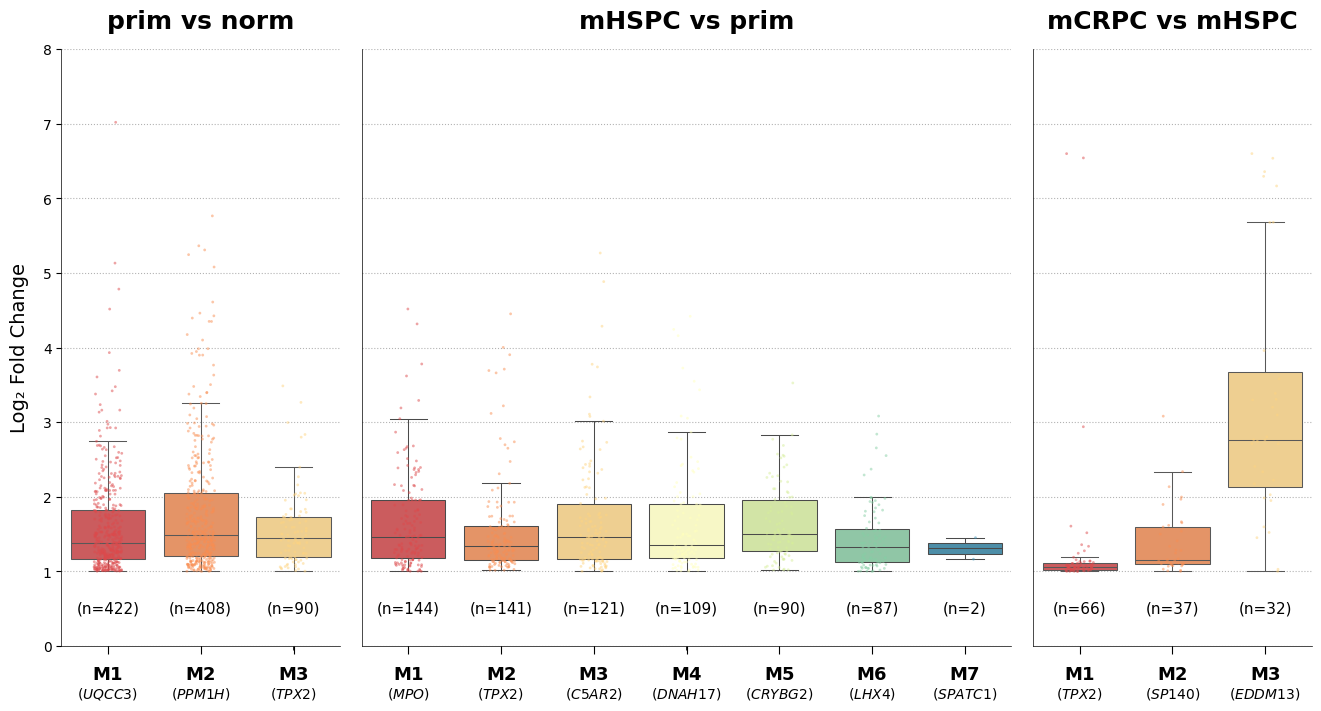

In [11]:
WGCNA_EXP_NAMES: Dict[str, str] = {
    "prim vs norm": "sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0",
    "mHSPC vs prim": "sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_up_1_0",
    "mCRPC vs mHSPC": "sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0",
}
combined_wgcna_boxplot(
    wgcna_exp_names=WGCNA_EXP_NAMES,
    figure_path=FIGURES_PATH,
    save_path_prefix="up",
    y_lim_bottom=0,
    y_lim_top=8,
)

### Down-regulated DEGs


Loading hub genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_down_1_0/standard/results/bicor_signed_hub_genes.csv
Loading network genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_down_1_0/standard/results/bicor_signed_network_genes.csv
Loading hub genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_down_1_0/standard/results/bicor_signed_hub_genes.csv
Loading network genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_down_1_0/standard/results/bicor_signed_network_genes.csv
Loading hub genes from: /Users/uziel/Data/PCTA_WCDT_GSE221601_FILTERED/wgcna/sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_down_1_0/standard/results/bicor_signed_hub_genes.csv
Loading network genes from: /Users/uziel/Data/PC

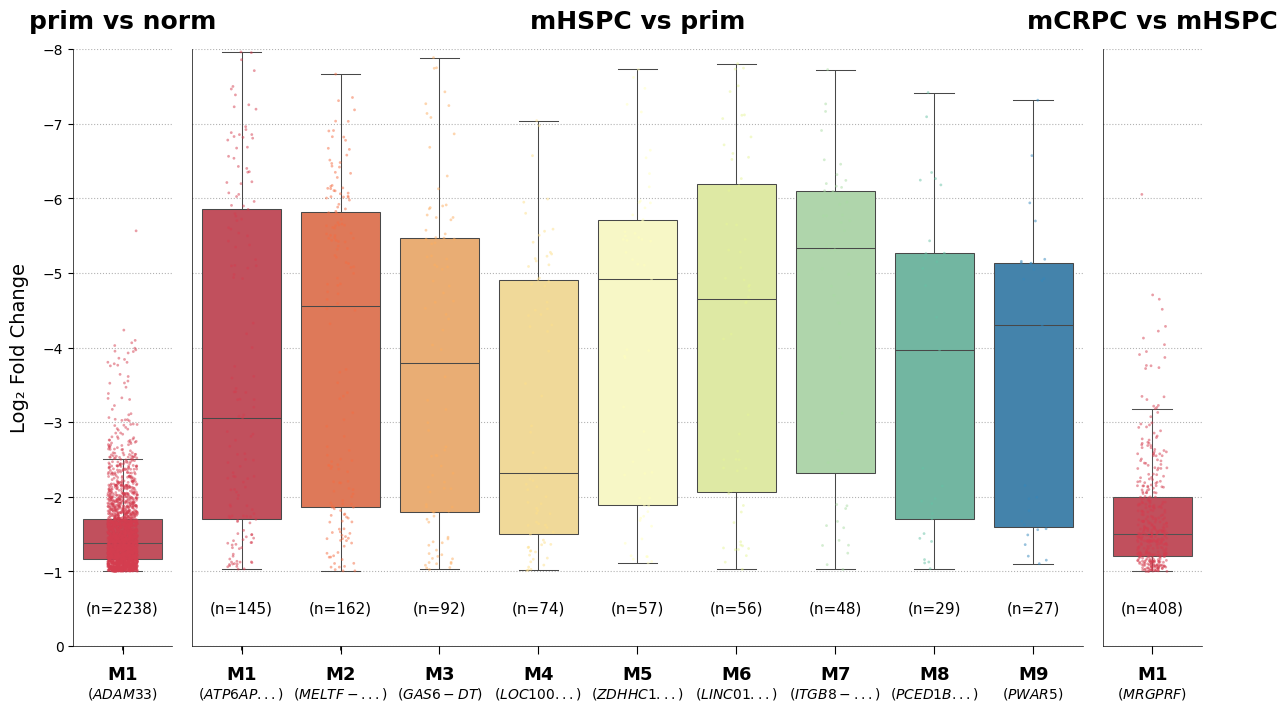

In [12]:
WGCNA_EXP_NAMES: Dict[str, str] = {
    "prim vs norm": "sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_down_1_0",
    "mHSPC vs prim": "sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_padj_0_05_down_1_0",
    "mCRPC vs mHSPC": "sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_down_1_0",
}

combined_wgcna_boxplot(
    wgcna_exp_names=WGCNA_EXP_NAMES,
    figure_path=FIGURES_PATH,
    save_path_prefix="down",
    y_lim_bottom=0,
    y_lim_top=-8,
)

## Additional files for WGCNA and ML analyses

---


### WGCNA DEGs


In [13]:
contrast_pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
level_pattern = r"(all|up|down)"

In [14]:
WGCNA_ROOT: Path = ROOT.joinpath("wgcna")
supplementary_file_wgcna = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_wgcna_degs.xlsx"),
    engine="openpyxl",
)

In [15]:
for wgcna_contrast_file in sorted(
    list(WGCNA_ROOT.rglob("*standard/results/bicor_signed_network_genes.csv"))
):
    contrast_match = re.search(contrast_pattern, str(wgcna_contrast_file))
    level_match = re.search(level_pattern, str(wgcna_contrast_file))

    if not contrast_match or not level_match:
        print(f"Skipping {wgcna_contrast_file} due to no match.")
        continue

    contrast = contrast_match.group(0)
    level = level_match.group(0)

    if level == "all":
        continue

    pd.read_csv(wgcna_contrast_file, index_col=0).sort_values("module").to_excel(
        supplementary_file_wgcna, sheet_name=f"{contrast}_{level}"
    )

In [16]:
supplementary_file_wgcna.close()

### WGCNA Pathways


In [17]:
WGCNA_ROOT: Path = ROOT.joinpath("wgcna")
supplementary_file_wgcna = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_wgcna_pathways.xlsx"),
    engine="openpyxl",
)

In [18]:
wgcna_modules_pathways = defaultdict(dict)
for wgcna_contrast_file in sorted(
    list(WGCNA_ROOT.rglob("*standard/functional/REACTOME/bicor_signed_M*_ora.csv"))
):
    contrast_match = re.search(contrast_pattern, str(wgcna_contrast_file))
    level_match = re.search(level_pattern, str(wgcna_contrast_file))
    module_id_match = re.search(r"M\d", wgcna_contrast_file.name)

    if not contrast_match or not level_match or not module_id_match:
        continue

    contrast = contrast_match.group(0)
    level = level_match.group(0)

    if level == "all":
        continue

    module_id = module_id_match.group(0)

    if module_id == "M0":
        continue

    wgcna_modules_pathways[(contrast, level)][module_id] = pd.read_csv(
        wgcna_contrast_file, index_col=0
    )

for (contrast, level), modules in wgcna_modules_pathways.items():
    contrast_pathways = []
    for module_id, pathways in modules.items():
        pathways["module"] = module_id
        contrast_pathways.append(pathways)

    if contrast_pathways:
        pd.concat(contrast_pathways).to_excel(
            supplementary_file_wgcna, sheet_name=f"{contrast}_{level}_reactome"
        )

In [19]:
supplementary_file_wgcna.close()

### ML


In [20]:
ML_ROOT: Path = ROOT.joinpath("ml_classifiers")
supplementary_file_ml = pd.ExcelWriter(
    SUPPLEMENTARY_FILES_PATH.joinpath("supplementary_file_ml.xlsx"),
    engine="openpyxl",
)

First-order SHAP values


In [21]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
for contrast_shap_values_file in sorted(
    list(ML_ROOT.rglob("*/light_gbm/**/bootstrap_8192_shap_values.csv"))
):
    match = re.search(pattern, contrast_shap_values_file.parents[3].name)
    if match:
        sheet_name = match.group(0) + "_shap"
        pd.read_csv(contrast_shap_values_file, index_col=0).to_excel(
            supplementary_file_ml, sheet_name=sheet_name
        )

Second-order SHAP values


In [22]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
for contrast_shap_values_file in sorted(
    list(ML_ROOT.rglob("*/light_gbm/**/bootstrap_8192_shap_interaction_summary.csv"))
):
    sheet_name = (
        re.search(pattern, contrast_shap_values_file.parents[3].name).group(0)
        + "_interactions"
    )
    pd.read_csv(contrast_shap_values_file, index_col=0).to_excel(
        supplementary_file_ml, sheet_name=sheet_name
    )

In [23]:
supplementary_file_ml.close()

## WGCNA Summary Table

---


In [24]:
WGCNA_ROOT: Path = ROOT.joinpath("wgcna")

In [25]:
# --- WGCNA Summary Table with Input DEGs in Total row ---
from collections import defaultdict

# Collect input DEGs for each contrast/level from vst_net.csv files
input_degs = defaultdict(lambda: "–")
for vst_net_file in sorted(WGCNA_ROOT.rglob("*standard/vst_net.csv")):
    vst_net_df = pd.read_csv(vst_net_file, index_col=0)
    contrast_match = re.search(contrast_pattern, str(vst_net_file))
    level_match = re.search(level_pattern, str(vst_net_file))
    if not contrast_match or not level_match:
        continue
    contrast = contrast_match.group(0).replace("_vs_", "/")
    level = level_match.group(0)
    if level == "all":
        continue
    input_degs[(contrast, level)] = vst_net_df.shape[1]

# Build summary for each contrast/level
wgcna_summary = {}
for wgcna_contrast_file in sorted(
    WGCNA_ROOT.rglob("*standard/results/bicor_signed_network_genes.csv")
):
    contrast_match = re.search(contrast_pattern, str(wgcna_contrast_file))
    level_match = re.search(level_pattern, str(wgcna_contrast_file))
    if not contrast_match or not level_match:
        continue
    contrast = contrast_match.group(0).replace("_vs_", "/")
    level = level_match.group(0)
    if level == "all":
        continue
    module_counts = (
        pd.read_csv(wgcna_contrast_file, index_col=0)
        .groupby("module")
        .count()
        .iloc[:, 0]
        .to_dict()
    )
    hub_genes_path = wgcna_contrast_file.parent / "bicor_signed_hub_genes.csv"
    if not hub_genes_path.exists():
        continue
    hub_genes = pd.read_csv(hub_genes_path, index_col=0)
    modules_meta = {}
    module_degs_cum = 0
    module_pathways_cum = 0
    for module_id, module_degs in module_counts.items():
        if module_id == "M0":
            continue
        pathway_file_path = (
            wgcna_contrast_file.parents[1]
            / "functional"
            / "REACTOME"
            / f"bicor_signed_{module_id}_ora.csv"
        )
        module_pathways = (
            len(pd.read_csv(pathway_file_path, index_col=0))
            if pathway_file_path.exists()
            else 0
        )
        if module_id not in hub_genes.index:
            continue
        hub_gene = hub_genes.loc[module_id, "SYMBOL"]
        modules_meta[module_id] = {
            "Hub gene": hub_gene,
            "Module genes": module_degs,
            "Enriched pathways": module_pathways,
        }
        module_degs_cum += module_degs
        module_pathways_cum += module_pathways
    if module_degs_cum > 0:
        modules_meta["Total"] = {
            "Input DEGs": input_degs.get((contrast, level), "–"),
            "Module genes": module_degs_cum,
            "Enriched pathways": module_pathways_cum,
        }
    if modules_meta:
        wgcna_summary[(contrast, level)] = modules_meta

# Build MultiIndex for rows
all_module_ids = set()
for modules_meta in wgcna_summary.values():
    all_module_ids.update(modules_meta.keys())
all_module_ids = natsort.natsorted(list(all_module_ids), alg=natsort.ns.PATH)
row_tuples = []
for module_id in all_module_ids:
    if module_id == "Total":
        for sub in ["Input DEGs", "Module genes", "Enriched pathways"]:
            row_tuples.append((module_id, sub))
    else:
        for sub in ["Hub gene", "Module genes", "Enriched pathways"]:
            row_tuples.append((module_id, sub))
row_index = pd.MultiIndex.from_tuples(row_tuples, names=["Module", "Info"])

# Build DataFrame
MISSING = "–"
summary_data = {}
for col, modules_meta in wgcna_summary.items():
    col_data = []
    for module_id in all_module_ids:
        if module_id == "Total":
            if module_id in modules_meta:
                col_data.append(modules_meta[module_id].get("Input DEGs", MISSING))
                col_data.append(modules_meta[module_id].get("Module genes", MISSING))
                col_data.append(
                    modules_meta[module_id].get("Enriched pathways", MISSING)
                )
            else:
                col_data.extend([MISSING, MISSING, MISSING])
        else:
            if module_id in modules_meta:
                col_data.append(modules_meta[module_id]["Hub gene"])
                col_data.append(modules_meta[module_id]["Module genes"])
                col_data.append(modules_meta[module_id]["Enriched pathways"])
            else:
                col_data.extend([MISSING, MISSING, MISSING])
    summary_data[col] = col_data

wgcna_summary_df = pd.DataFrame(summary_data, index=row_index)
wgcna_summary_df = wgcna_summary_df.reindex(
    columns=pd.MultiIndex.from_tuples(
        [
            ("prim/norm", "up"),
            ("prim/norm", "down"),
            ("hspc/prim", "up"),
            ("hspc/prim", "down"),
            ("mcrpc/hspc", "up"),
            ("mcrpc/hspc", "down"),
        ]
    )
)
wgcna_summary_df.to_excel(
    SUPPLEMENTARY_FILES_PATH.joinpath("wgcna_summary_table.xlsx"),
    sheet_name="WGCNA_summary",
)
wgcna_summary_df

prim/norm         hspc/prim               mcrpc/hspc  \
                                up    down        up          down         up   
Module Info                                                                     
M1     Hub gene              UQCC3  ADAM33       MPO    ATP6AP1-DT       TPX2   
       Module genes            422    2238       144           168         66   
       Enriched pathways        35       3         1             0         31   
M2     Hub gene              PPM1H       –      TPX2     MELTF-AS1      SP140   
       Module genes            408       –       141           166         37   
       Enriched pathways         0       –        58             0          3   
M3     Hub gene               TPX2       –     C5AR2       GAS6-DT     EDDM13   
       Module genes             90       –       121            92         32   
       Enriched pathways        24       –         3             0          0   
M4     Hub gene                  –       –    DNAH17  LOC100288123          –   
       Module genes              –       –       109            75          –   
       Enriched pathways         –       –         0             0          –   
M5     Hub gene                  –       –    CRYBG2    ZDHHC12-DT          –   
       Module genes              –       –        90            61          –   
       Enriched pathways         –       –         1             0          –   
M6     Hub gene                  –       –      LHX4     LINC01679          –   
       Module genes              –       –        87            58          –   
       Enriched pathways         –       –         0             0          –   
M7     Hub gene                  –       –    SPATC1     ITGB8-AS1          –   
       Module genes              –       –         2            49          –   
       Enriched pathways         –       –         4             0          –   
M8     Hub gene                  –       –         –    PCED1B-AS1          –   
       Module genes              –       –         –            29          –   
       Enriched pathways         –       –         –             1          –   
M9     Hub gene                  –       –         –         PWAR5          –   
       Module genes              –       –         –            28          –   
       Enriched pathways         –       –         –             1          –   
Total  Input DEGs             1137    2656      1193           976       1873   
       Module genes            920    2238       694           726        135   
       Enriched pathways        59       3        67             2         34   

                                  
                            down  
Module Info                       
M1     Hub gene           MRGPRF  
       Module genes          409  
       Enriched pathways       0  
M2     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
M3     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
M4     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
M5     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
M6     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
M7     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
M8     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
M9     Hub gene                –  
       Module genes            –  
       Enriched pathways       –  
Total  Input DEGs            609  
       Module genes          409  
       Enriched pathways       0

## ML Bootstrap Test Metrics

---


In [26]:
ML_ROOT: Path = ROOT.joinpath("ml_classifiers")

In [27]:
pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
test_scores = {}
for contrast_shap_values_file in sorted(
    list(
        ML_ROOT.rglob(
            "*M3+M2+M1*/light_gbm/genes_features/bootstrap/bootstrap_8192_test_scores.csv"
        )
    )
):
    match = re.search(pattern, contrast_shap_values_file.parents[3].name)
    if match:
        contrast = match.group(0).replace("_vs_", "/")
        df = pd.read_csv(contrast_shap_values_file, index_col=0)
        test_scores[contrast] = {
            col: f"{df[col].mean():.3f}±{df[col].std():.3f}" for col in df.columns
        }

test_scores_df = pd.DataFrame(test_scores).T  # contrasts as rows
# Map metric names to human-readable
metric_map = {
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1 Score",
    "balanced_accuracy": "Balanced Accuracy",
}
test_scores_df = test_scores_df.rename(columns=metric_map)
# Filter and order rows
test_scores_df = test_scores_df.loc[["prim/norm", "hspc/prim", "mcrpc/hspc"]]

output_path = SUPPLEMENTARY_FILES_PATH.joinpath("ml_bootstrap_test_scores.xlsx")
test_scores_df.to_excel(output_path)

display(test_scores_df)

,Precision,Recall,F1 Score,Balanced Accuracy
prim/norm,0.959±0.015,0.992±0.008,0.975±0.008,0.917±0.029
hspc/prim,0.955±0.010,0.989±0.010,0.972±0.007,0.686±0.073
mcrpc/hspc,0.912±0.017,0.978±0.018,0.943±0.013,0.665±0.070


## Statistical power of each pair-wise comparison

---


In [28]:
contrast_comparisons: List[Tuple[str, str]] = [
    ("prim", "norm"),
    ("hspc", "prim"),
    ("mcrpc", "hspc"),
]

In [29]:
ANNOT_DF: pd.DataFrame = pd.read_csv(
    ROOT.joinpath("data").joinpath("samples_annotation.csv"),
    index_col=0,
)
display(ANNOT_DF)

,patient_id,sample_type,dataset,library_type
sample_id,,,,
entry_357,TCGA-G9-6342-01,prim,TCGA,poly_a
entry_498,TCGA-VP-A875-01,prim,TCGA,poly_a
entry_520,TCGA-J4-A83I-01,prim,TCGA,poly_a
entry_521,TCGA-EJ-A8FP-01,prim,TCGA,poly_a
entry_522,TCGA-J4-A83J-01,prim,TCGA,poly_a
...,...,...,...,...
SRR22868633,SAMN32372352,hspc,GSE221601,total_rna
SRR22868634,SAMN32372353,hspc,GSE221601,total_rna
SRR22868635,SAMN32372354,hspc,GSE221601,total_rna


In [30]:
for test, control in contrast_comparisons:
    test_df = ANNOT_DF[ANNOT_DF["sample_type"] == test]
    control_df = ANNOT_DF[ANNOT_DF["sample_type"] == control]

    n_test = len(test_df)
    n_control = len(control_df)
    print(f"{test} vs {control}: n_test={n_test}, n_control={n_control}")

    if n_test < 2 or n_control < 2:
        print(
            f"Not enough samples for {test} vs {control} (need at least 2 per group). Skipping."
        )
        continue

    # Always use the smaller group as nobs1, and ensure ratio >= 1
    if n_test <= n_control:
        nobs1 = n_test
        nobs2 = n_control
        group1, group2 = test, control
    else:
        nobs1 = n_control
        nobs2 = n_test
        group1, group2 = control, test
    ratio = nobs2 / nobs1

    effect_size = 0.5
    alpha = 0.05

    try:
        power = tt_ind_solve_power(
            effect_size=effect_size,
            nobs1=nobs1,
            alpha=alpha,
            ratio=ratio,
            alternative="two-sided",
        )
        print(
            f"Statistical power for {group1} vs {group2} (alpha=0.05, d={effect_size}): {power:.2f}"
        )
    except Exception as e:
        print(f"Power calculation failed for {group1} vs {group2}: {e}")

prim vs norm: n_test=662, n_control=182
Statistical power for norm vs prim (alpha=0.05, d=0.5): 1.00
hspc vs prim: n_test=52, n_control=662
Statistical power for hspc vs prim (alpha=0.05, d=0.5): 0.93
mcrpc vs hspc: n_test=336, n_control=52
Statistical power for hspc vs mcrpc (alpha=0.05, d=0.5): 0.92


## SHAP Interaction Values Heatmap

---


In [31]:
ML_ROOT: Path = ROOT.joinpath("ml_classifiers")

pattern = r"(prim_vs_norm|hspc_vs_prim|mcrpc_vs_hspc)"
shap_interaction_summaries_df = {}
for contrast_shap_values_file in sorted(
    list(
        ML_ROOT.rglob(
            "*M3+M2+M1*/light_gbm/genes_features/bootstrap/bootstrap_8192_shap_interaction_summary.csv"
        )
    )
):
    match = re.search(pattern, contrast_shap_values_file.parents[3].name)
    if match:
        contrast = match.group(0).replace("_vs_", "/")
        shap_interaction_summaries_df[contrast] = pd.read_csv(
            contrast_shap_values_file, index_col=0
        )

In [32]:
def plot_shap_interaction_heatmaps(
    shap_interaction_summaries_df, figsize=(9, 8), cmap="coolwarm", save_dir=None
):
    """
    Plots a lower-triangle heatmap for each SHAP interaction matrix in the provided dictionary.
    Args:
        shap_interaction_summaries_df (dict): Dict of {contrast: pd.DataFrame}.
        figsize (tuple): Figure size for each heatmap.
        cmap (str): Colormap for heatmaps. Default is 'coolwarm'.
        save_dir (Path or str, optional): Directory to save figures. If None, does not save.
    """
    # Mapping for pretty titles
    contrast_title_map = {
        "prim/norm": "prim vs norm",
        "hspc/prim": "mHSPC vs prim",
        "mcrpc/hspc": "mCRPC vs mHSPC",
    }

    for contrast, df in shap_interaction_summaries_df.items():
        # Use absolute values
        abs_df = df.abs()

        mask = np.triu(np.ones(abs_df.shape, dtype=bool))
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
            abs_df,
            mask=mask,
            cmap=cmap,
            square=True,
            linewidths=0.5,
            linecolor="#e0e0e0",
            cbar_kws={"shrink": 0.8, "label": "|SHAP Interaction|"},
            xticklabels=True,
            yticklabels=True,
            annot=False,
        )
        # Use mapped title or fallback to contrast
        pretty_title = contrast_title_map.get(contrast) or contrast
        ax.set_title(pretty_title, fontsize=18, fontweight="bold", pad=18)
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.xticks(rotation=45, ha="right", fontsize=11)
        plt.yticks(rotation=0, fontsize=11)
        # Remove top/right spines for a clean look
        for spine in ["top", "right", "left", "bottom"]:
            ax.spines[spine].set_visible(False)
        if save_dir is not None:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)
            fname_base = f"shap_interaction_heatmap_{contrast.replace('/', '_')}"
            plt.savefig(save_dir / f"{fname_base}.pdf", bbox_inches="tight")
            plt.savefig(save_dir / f"{fname_base}.png", dpi=300, bbox_inches="tight")
        plt.show()

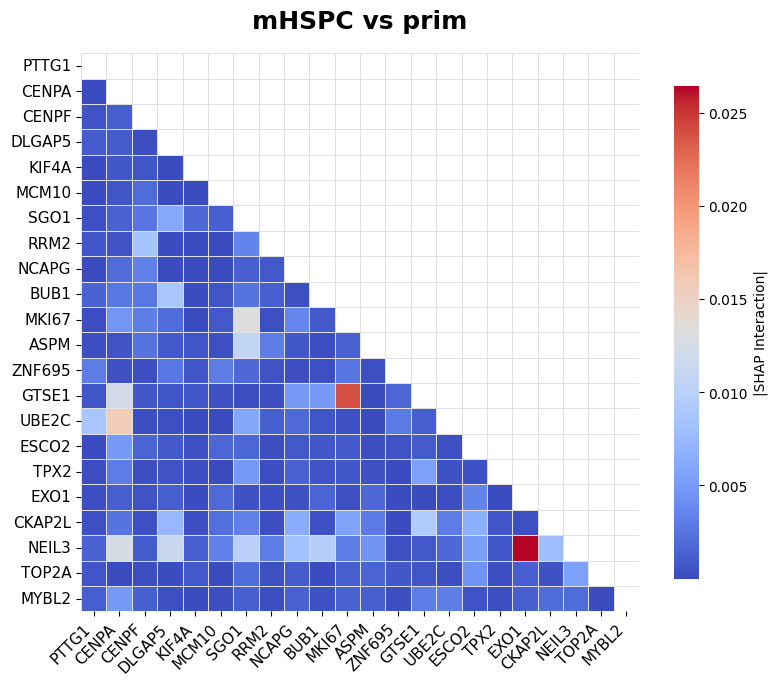

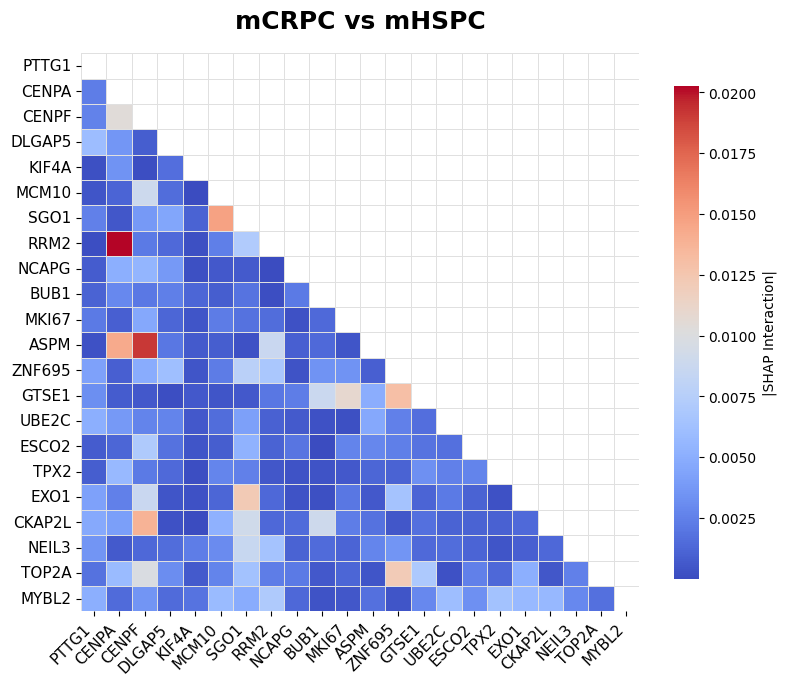

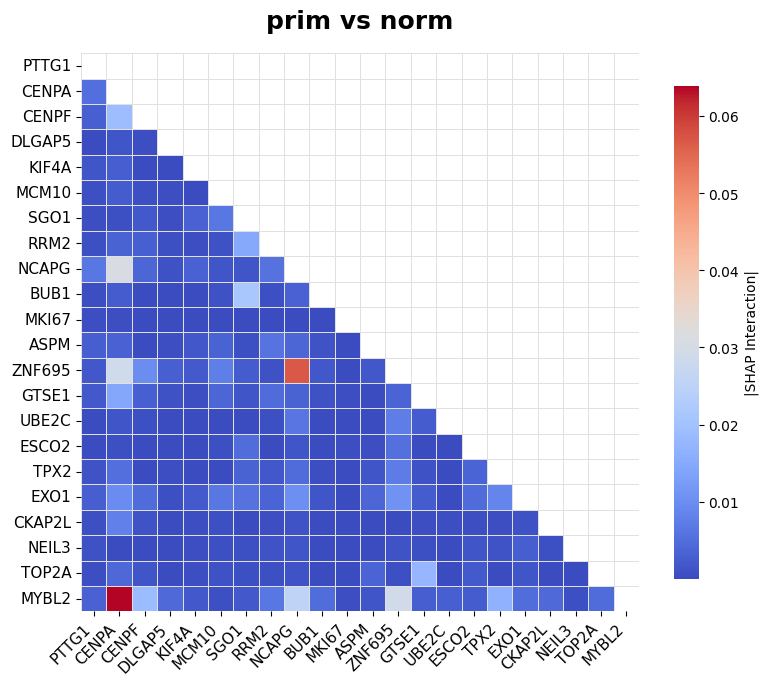

In [33]:
plot_shap_interaction_heatmaps(shap_interaction_summaries_df, save_dir=FIGURES_PATH)

## Boxplot for all WGCNA shared DEGs

---


In [34]:
INT_RES_FILE: Path = (
    ROOT
    / "integrative_analysis"
    / "intersecting_wgcna"
    / "comparison_0_padj_0_05_up_1_0_bicor_signed_intersecting_wgcna_M3+M2+M1_ENTREZID_22.csv"
)
wgcna_inter_results = pd.read_csv(INT_RES_FILE, index_col=0)

shared_degs_df = wgcna_inter_results.loc[
    wgcna_inter_results["prim_vs_norm_M3"]
    & wgcna_inter_results["hspc_vs_prim_M2"]
    & wgcna_inter_results["mcrpc_vs_hspc_M1"]
].drop(columns=["prim_vs_norm_M3", "hspc_vs_prim_M2", "mcrpc_vs_hspc_M1"])

display(shared_degs_df)

SHARED_DEGS: List[str] = shared_degs_df["SYMBOL"].tolist()

,module,stat,SYMBOL,GENENAME,GENETYPE
ENTREZID,,,,,
9232,M3,12.142774,PTTG1,PTTG1 regulator of sister chromatid separation...,protein-coding
1058,M3,14.746854,CENPA,centromere protein A,protein-coding
1063,M3,18.528588,CENPF,centromere protein F,protein-coding
9787,M3,17.270347,DLGAP5,DLG associated protein 5,protein-coding
24137,M3,19.737857,KIF4A,kinesin family member 4A,protein-coding
55388,M3,12.942387,MCM10,minichromosome maintenance 10 replication init...,protein-coding
151648,M3,11.564943,SGO1,shugoshin 1,protein-coding
6241,M3,20.239389,RRM2,ribonucleotide reductase regulatory subunit M2,protein-coding
64151,M3,14.085327,NCAPG,non-SMC condensin I complex subunit G,protein-coding


In [35]:
CONTRASTS_LEVELS_COLORS = {
    "mcrpc": "#8B3A3A",
    "prim": "#4A708B",
    "hspc": "#8B008B",
    "norm": "#9ACD32",
}

CONTRASTS_LEVELS_ORDER = ["norm", "prim", "hspc", "mcrpc"]

In [36]:
degs_norm_vst = pd.read_csv(
    ROOT
    / "wgcna"
    / "sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0"
    / "standard"
    / "vst_net.csv",
    index_col=0,
).loc[
    ANNOT_DF[ANNOT_DF["sample_type"] == "norm"].index,
    shared_degs_df.index.astype(str).tolist(),
]

degs_prim_vst = pd.read_csv(
    ROOT
    / "wgcna"
    / "sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_padj_0_05_up_1_0"
    / "standard"
    / "vst_net.csv",
    index_col=0,
).loc[
    ANNOT_DF[ANNOT_DF["sample_type"] == "prim"].index,
    shared_degs_df.index.astype(str).tolist(),
]

degs_hspc_vst = pd.read_csv(
    ROOT
    / "wgcna"
    / "sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0"
    / "standard"
    / "vst_net.csv",
    index_col=0,
).loc[
    ANNOT_DF[ANNOT_DF["sample_type"] == "hspc"].index,
    shared_degs_df.index.astype(str).tolist(),
]

degs_mcrpc_vst = pd.read_csv(
    ROOT
    / "wgcna"
    / "sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_padj_0_05_up_1_0"
    / "standard"
    / "vst_net.csv",
    index_col=0,
).loc[
    ANNOT_DF[ANNOT_DF["sample_type"] == "mcrpc"].index,
    shared_degs_df.index.astype(str).tolist(),
]

prim_norm_degs_df = pd.read_csv(
    ROOT
    / "deseq2"
    / ("sample_type_hspc+mcrpc+norm+prim__prim_vs_norm_deseq_results_unique.csv"),
    index_col=0,
)
hspc_prim_degs_df = pd.read_csv(
    ROOT
    / "deseq2"
    / ("sample_type_hspc+mcrpc+norm+prim__hspc_vs_prim_deseq_results_unique.csv"),
    index_col=0,
)
mcrpc_hspc_degs_df = pd.read_csv(
    ROOT
    / "deseq2"
    / ("sample_type_hspc+mcrpc+norm+prim__mcrpc_vs_hspc_deseq_results_unique.csv"),
    index_col=0,
)

degs_dfs = {
    "prim_norm": prim_norm_degs_df.set_index("SYMBOL").loc[SHARED_DEGS],
    "hspc_prim": hspc_prim_degs_df.set_index("SYMBOL").loc[SHARED_DEGS],
    "mcrpc_hspc": mcrpc_hspc_degs_df.set_index("SYMBOL").loc[SHARED_DEGS],
}

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


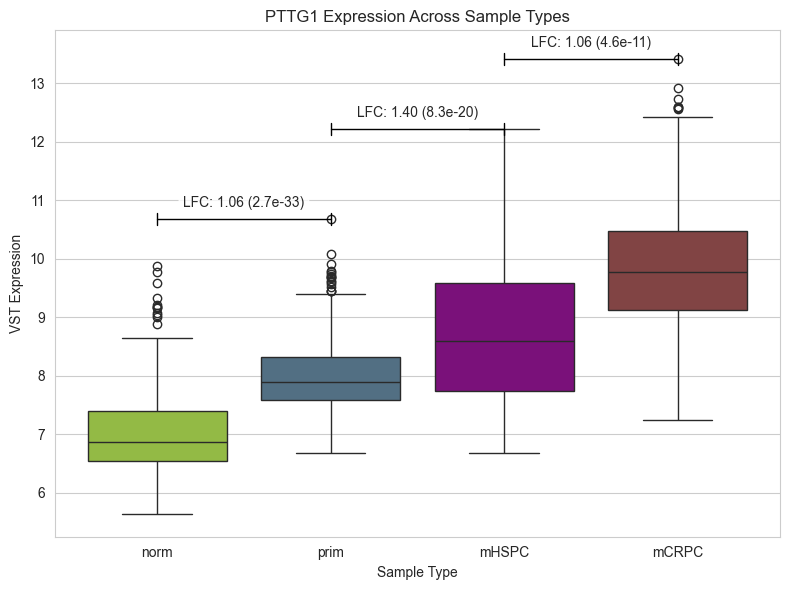

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


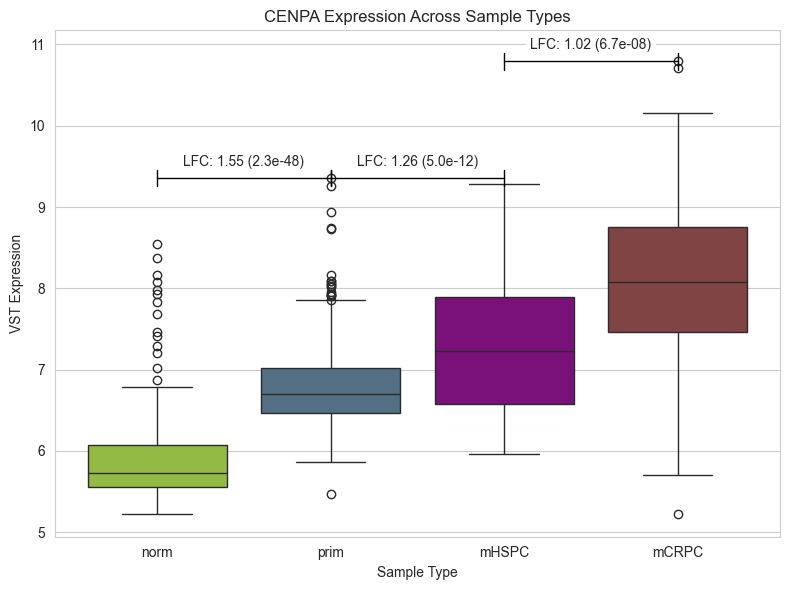

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


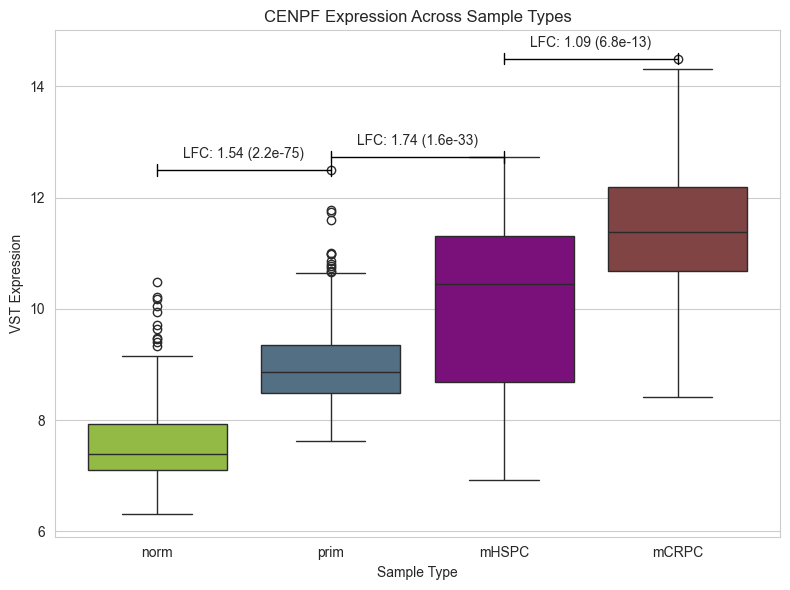

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


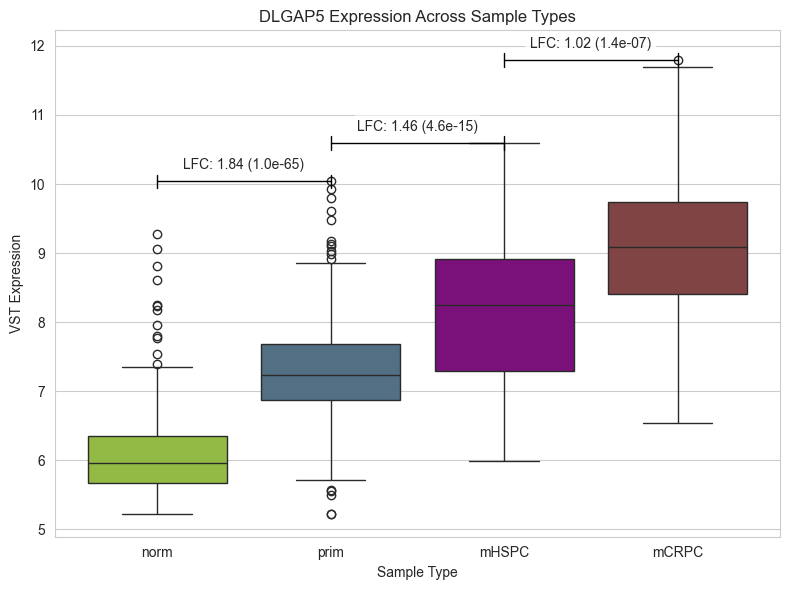

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


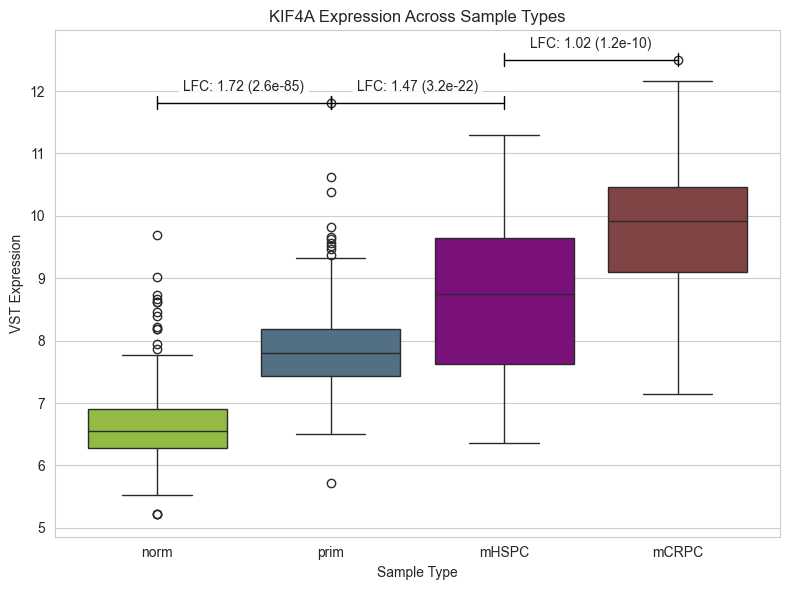

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


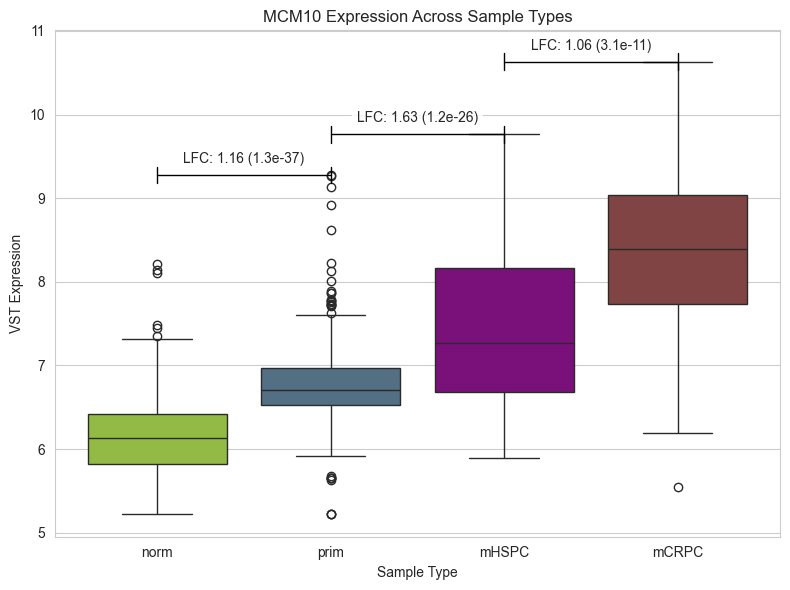

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


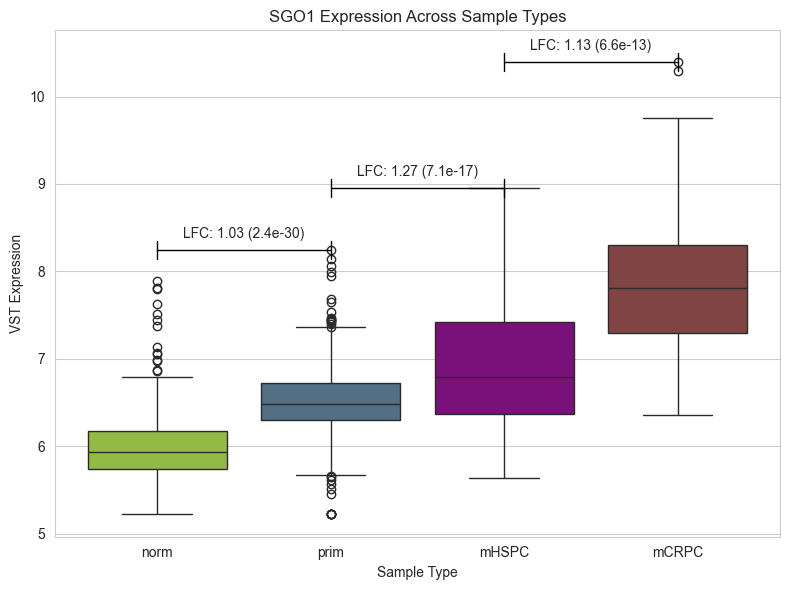

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


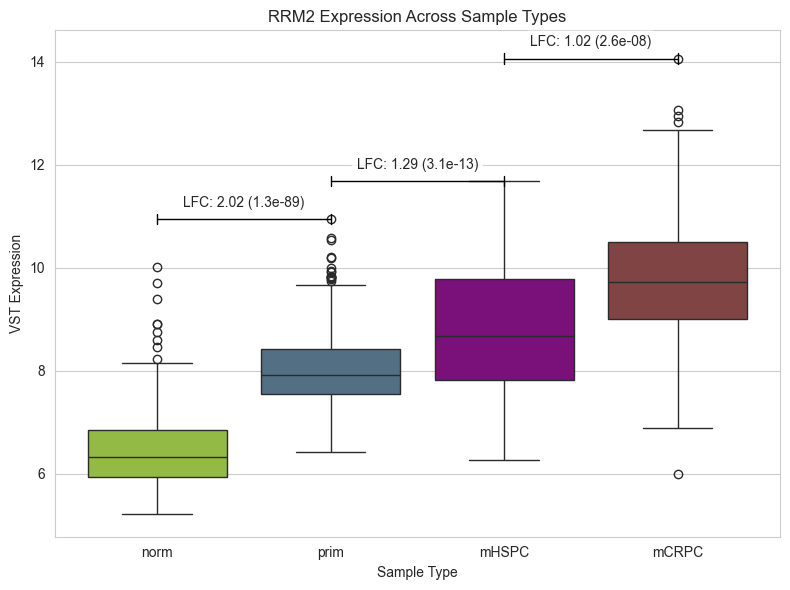

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


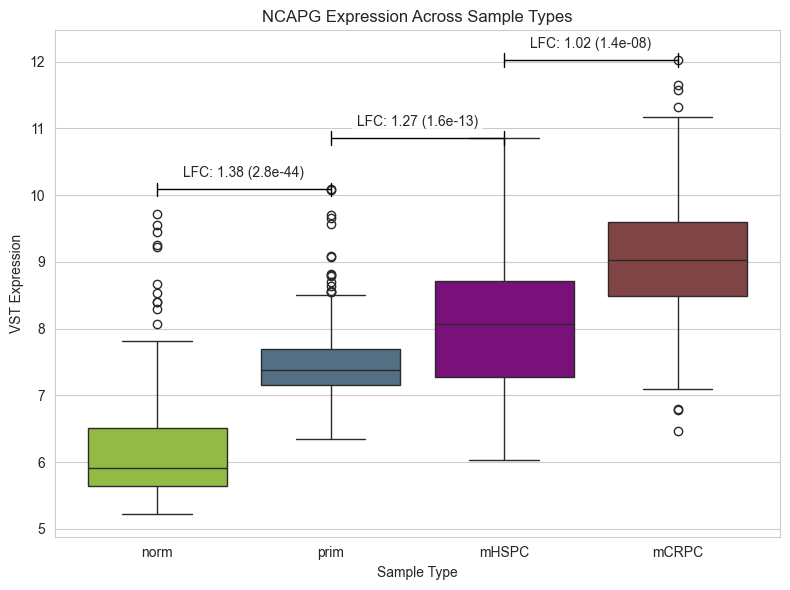

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


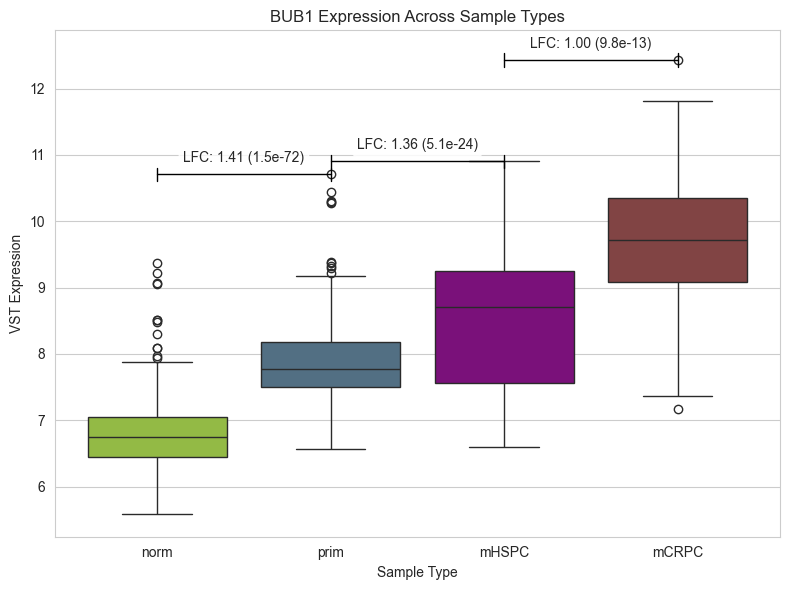

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


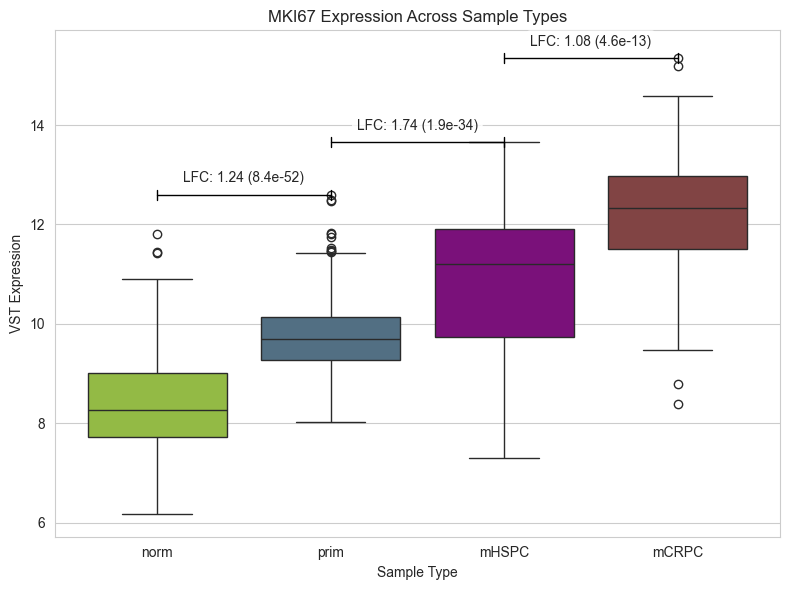

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


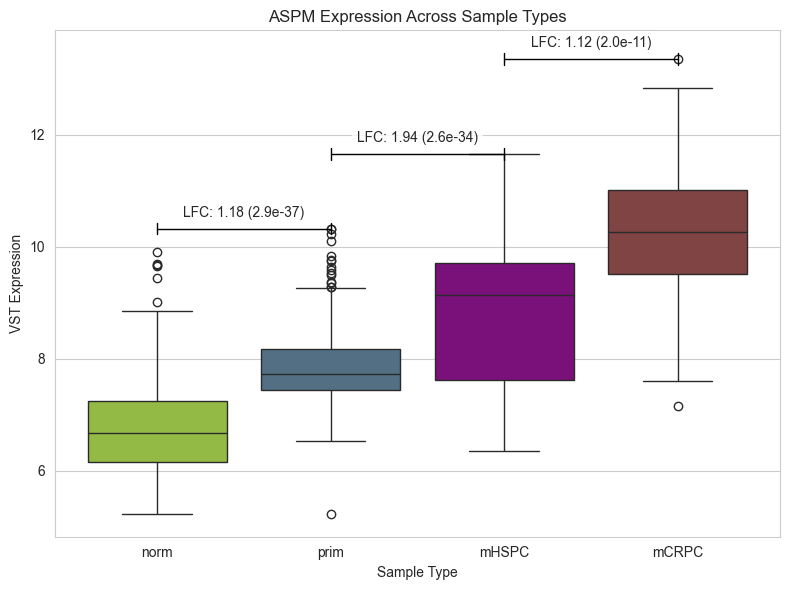

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


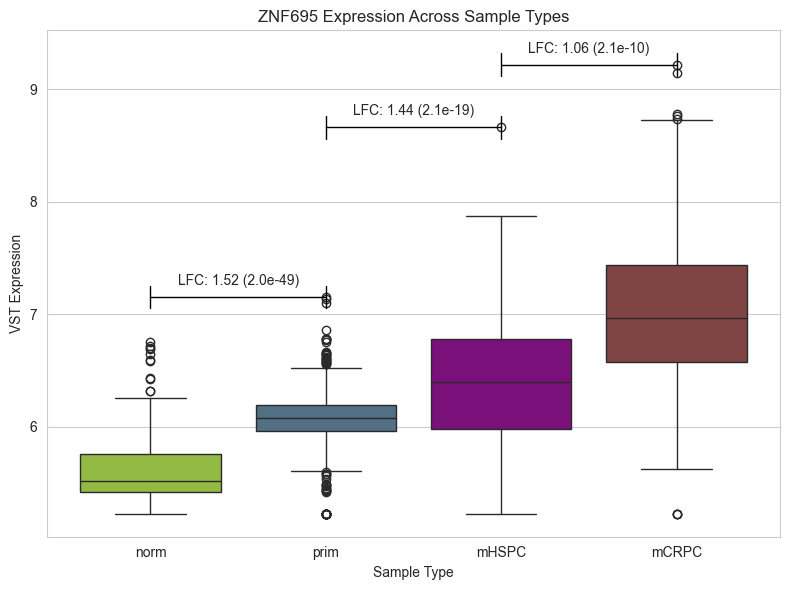

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


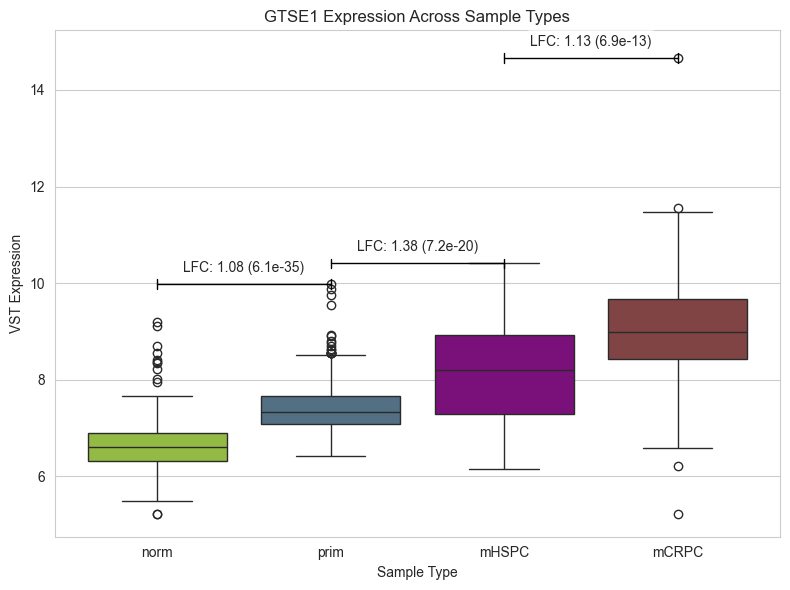

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


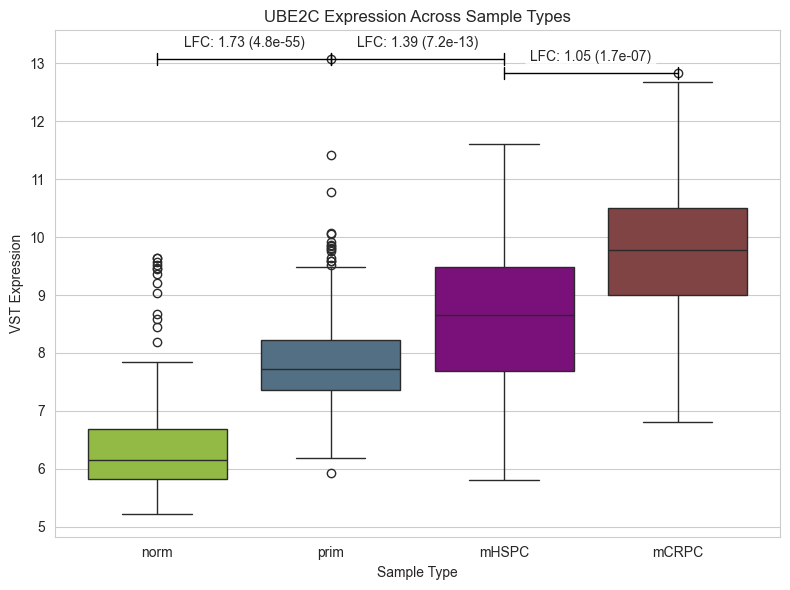

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


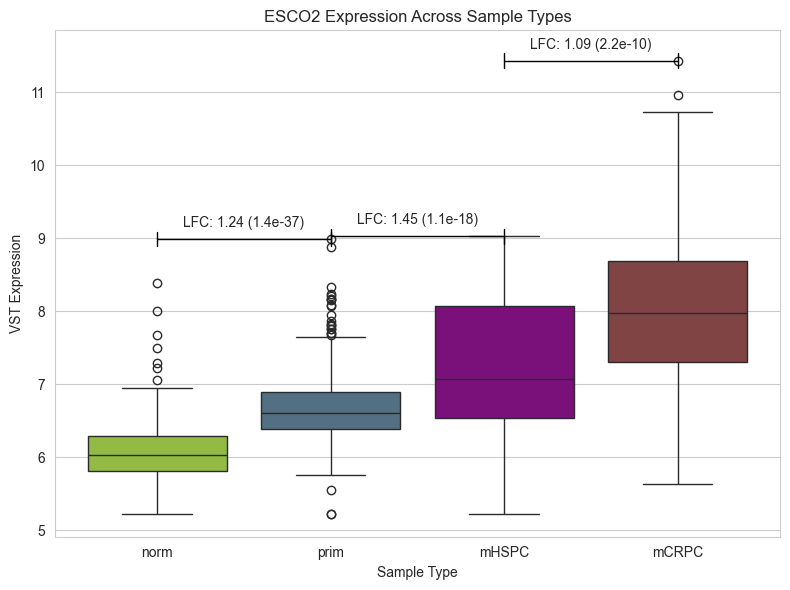

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


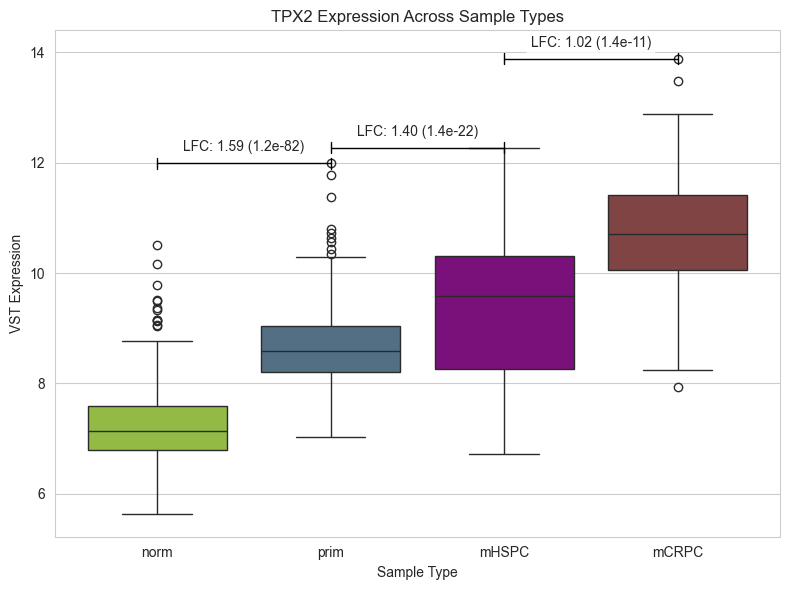

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


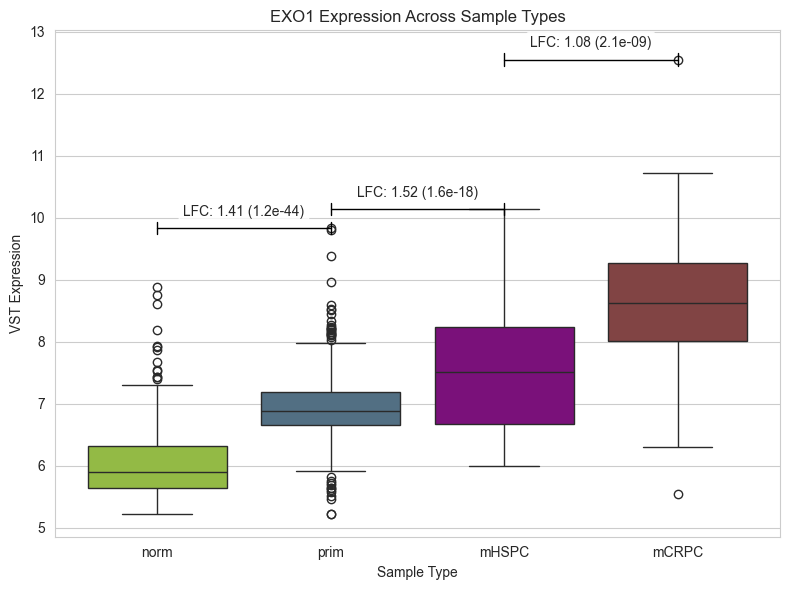

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


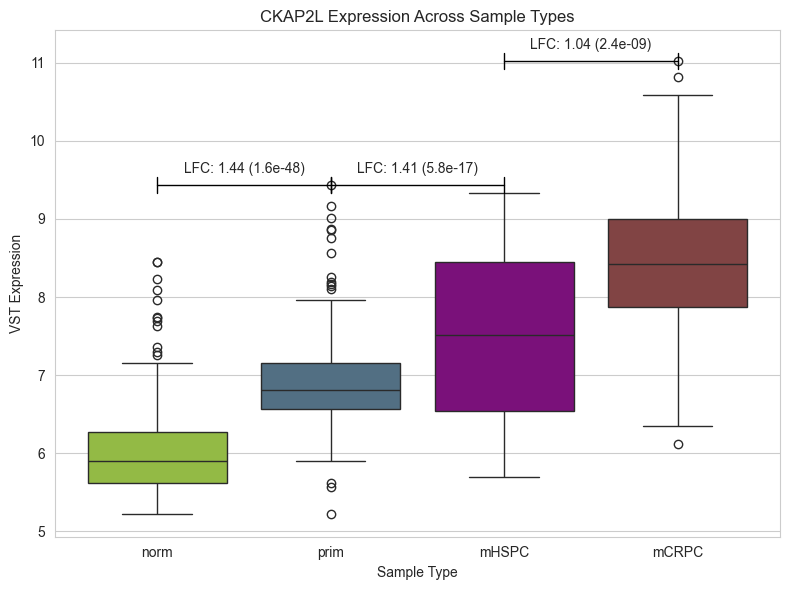

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


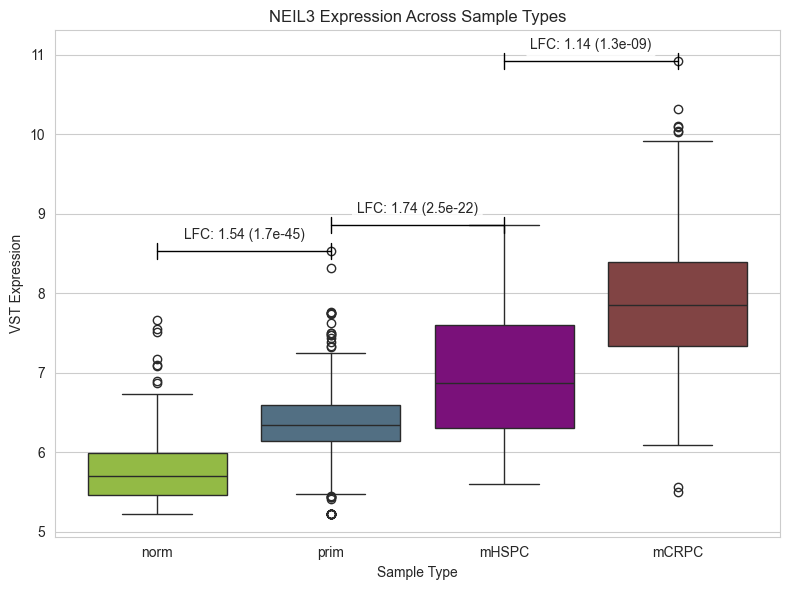

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


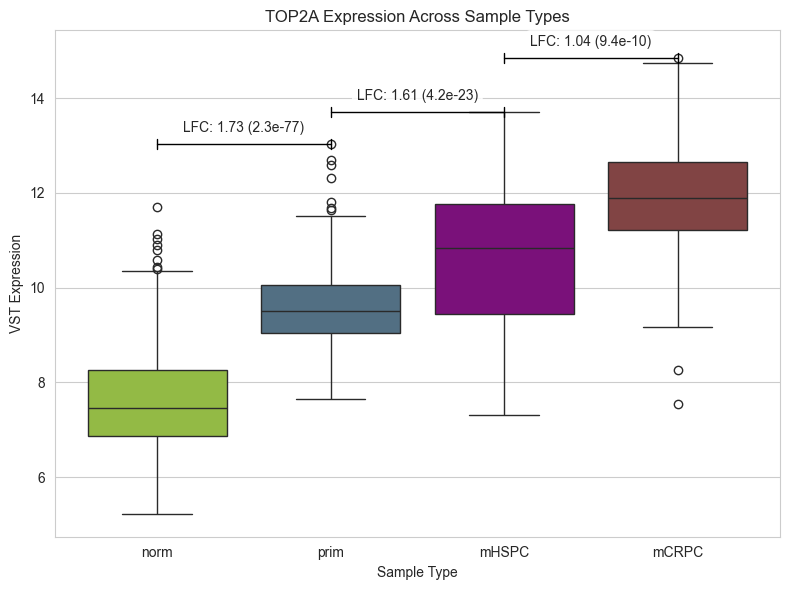

/var/folders/zr/mgk4g4bn5xv_ppx_fl1qj37w0000gn/T/ipykernel_15615/1220011919.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])


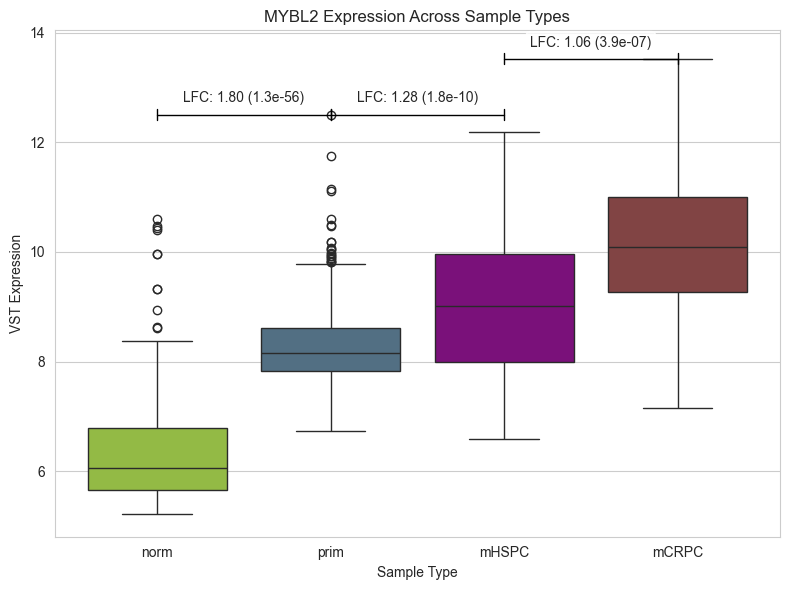

In [38]:
for shared_gene in SHARED_DEGS:
    
    # Get gene expression data
    shared_gene_entrezid = (
        shared_degs_df.loc[shared_degs_df["SYMBOL"] == shared_gene]
        .index.astype(str)
        .tolist()[0]
    )
    gene_norm_vst = degs_norm_vst[shared_gene_entrezid]
    gene_prim_vst = degs_prim_vst[shared_gene_entrezid]
    gene_hspc_vst = degs_hspc_vst[shared_gene_entrezid]
    gene_mcrpc_vst = degs_mcrpc_vst[shared_gene_entrezid]

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(
        {
            "VST Expression": pd.concat(
                [
                    gene_norm_vst,
                    gene_prim_vst,
                    gene_hspc_vst,
                    gene_mcrpc_vst,
                ]
            ),
            "Sample Type": pd.concat(
                [
                    pd.Series("norm", index=gene_norm_vst.index),
                    pd.Series("prim", index=gene_prim_vst.index),
                    pd.Series("hspc", index=gene_hspc_vst.index),
                    pd.Series("mcrpc", index=gene_mcrpc_vst.index),
                ]
            ),
        }
    )

    # Set style and figure size
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")

    # Create box plot
    box_plot = sns.boxplot(
        data=plot_df,
        x="Sample Type",
        y="VST Expression",
        order=CONTRASTS_LEVELS_ORDER,
        palette=CONTRASTS_LEVELS_COLORS,
        hue="Sample Type",
        legend=False,
    )

    plt.gca().set_xticklabels(["norm", "prim", "mHSPC", "mCRPC"])

    # Add statistical annotations and horizontal lines
    for i in range(len(CONTRASTS_LEVELS_ORDER) - 1):
        first_level = CONTRASTS_LEVELS_ORDER[i]
        second_level = CONTRASTS_LEVELS_ORDER[i + 1]
        comparison = f"{second_level}_{first_level}"

        # Get statistical values
        log2fc = degs_dfs[comparison].loc[shared_gene, "log2FoldChange"]
        padj = degs_dfs[comparison].loc[shared_gene, "padj"]

        # Format annotation text
        annotation = f"LFC: {log2fc:.2f} ({padj:.1e})"

        # Calculate y positions for lines and text
        # Get the max value for each box in the comparison
        violin1_data = plot_df[plot_df["Sample Type"] == first_level]["VST Expression"]
        violin2_data = plot_df[plot_df["Sample Type"] == second_level]["VST Expression"]
        max_height = max(violin1_data.max(), violin2_data.max())

        # Position text closer to the whiskers
        text_y_pos = (
            max_height
            + (plot_df["VST Expression"].max() - plot_df["VST Expression"].min()) * 0.02
        )
        # Position line slightly below the text
        line_y_pos = (
            text_y_pos
            - (plot_df["VST Expression"].max() - plot_df["VST Expression"].min()) * 0.02
        )

        # Add annotation
        plt.annotate(
            annotation,
            xy=(i + 0.5, text_y_pos),
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

        # Add horizontal line with whiskers
        plt.plot(
            [i, i + 1],
            [line_y_pos, line_y_pos],
            color="black",
            linestyle="-",
            linewidth=1,
        )
        plt.plot(
            [i, i],
            [line_y_pos - 0.1, line_y_pos + 0.1],
            color="black",
            linestyle="-",
            linewidth=1,
        )
        plt.plot(
            [i + 1, i + 1],
            [line_y_pos - 0.1, line_y_pos + 0.1],
            color="black",
            linestyle="-",
            linewidth=1,
        )

    # Customize plot
    plt.title(f"{shared_gene} Expression Across Sample Types")
    plt.tight_layout()

    # Save plot
    plt.savefig(FIGURES_PATH / f"{shared_gene.lower()}_expression_box.pdf")
    plt.show()
